In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/colabs/student_performance.csv'


Mounted at /content/drive


now i need to load the data with pandas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [ ]:
import pandas as pd
data = pd.read_csv(dataset_path)
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [ ]:
print(data.info())
print(data.select_dtypes(include='object').nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None
Extracurricular Activities    2
dtype: int64


In [ ]:
data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})


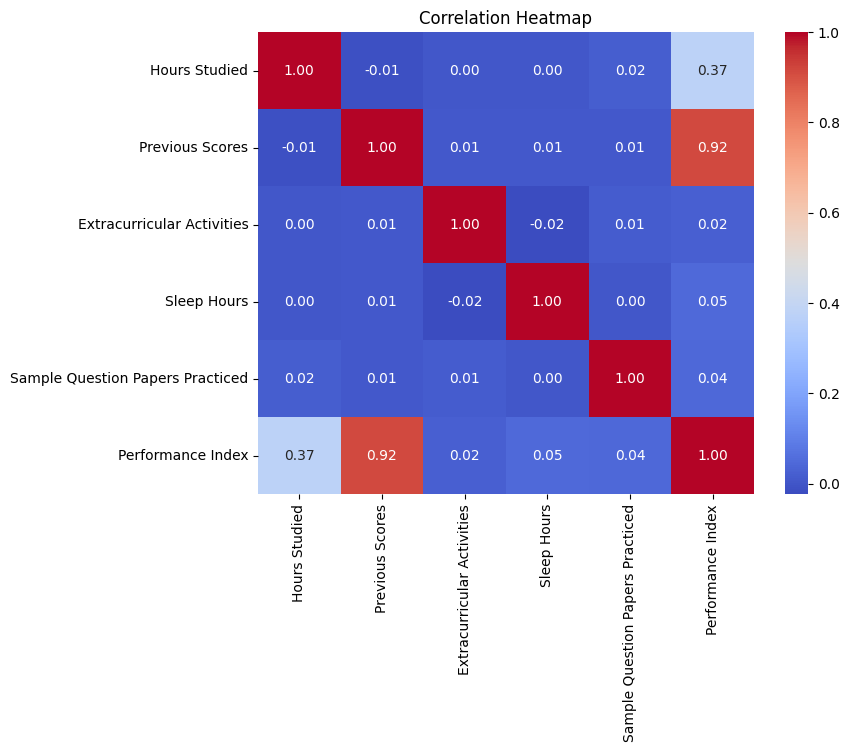

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

i need to handle missing data

In [ ]:
data.isnull().sum()
if data.isnull().sum().sum() > 0:
  print('there are missing values')
  data.fillna(data.median(numeric_only=True), inplace=True)  # Fill missing numeric data with median
  data.fillna('Unknown', inplace=True)
else:
  print('there are no missing values')

there are no missing values


i need to check if there are duplicates

In [ ]:
if data.duplicated().sum() < 1:
  print('no duplicates')
else:
  print('there are duplicates')
  data.drop_duplicates(inplace=True)


there are duplicates


im gonna prepare data for modeling

In [ ]:
X = data.drop(columns=["Performance Index"])
y = data["Performance Index"]


In [ ]:
y = PowerTransformer().fit_transform(y.values.reshape(-1, 1)).ravel()


now im gonna split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
numerical_features = ["Hours Studied", "Previous Scores", "Sleep Hours", "Sample Question Papers Practiced"]
categorical_features = ["Extracurricular Activities"]

In [ ]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_features),
    ('cat', 'passthrough', categorical_features)  # Категориальный признак уже закодирован (0/1)
])

im evaluating with cross-validation

In [ ]:
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)


im gonna create a pipeline

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

and now im gonna train it

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Hours Studied',
                                                   'Previous Scores',
                                                   'Sleep Hours',
                                                   'Sample Question Papers '
                                                   'Practiced']),
                                                 ('cat', 'passthrough',
                                                  ['Extracurricular '
                                                   'Activities'])])),
                ('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=300,
                                           random_state=42))])

accuracy

In [ ]:
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train R²: {train_score:.3f}")
print(f"Test R²: {test_score:.3f}")

Train R²: 0.991
Test R²: 0.987


hyperparameter tuning

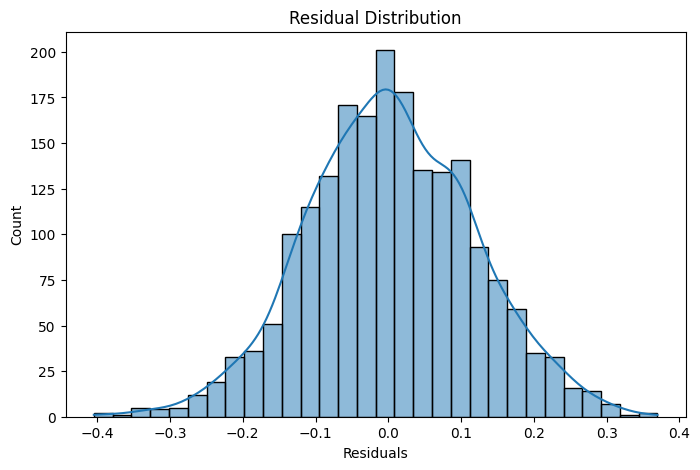

In [ ]:
y_pred = pipeline.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.show()

visualizations

In [ ]:
import pandas as pd

# 🔹 1. Если `y` уже numpy-массив, превращаем его обратно в `Series`
if isinstance(y, np.ndarray):
    y = pd.Series(y)

# 🔹 2. Убираем пропущенные значения перед обучением
X_train = X_train.dropna().reset_index(drop=True)  # Сбрасываем индексы
y = y.iloc[X_train.index].reset_index(drop=True)  # Берём те же индексы, что и X_train

# 🔹 3. Применяем PowerTransformer
from sklearn.preprocessing import PowerTransformer

power_transformer = PowerTransformer()
y_transformed = power_transformer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Проверяем размеры после преобразования
print(f"Размер X_train: {X_train.shape[0]}, Размер y_transformed: {y_transformed.shape[0]}")

# 🔹 4. Обучаем модель
pipeline.fit(X_train, y_transformed)

# 🔹 5. Предсказываем для нового студента
new_student = pd.DataFrame({
    "Hours Studied": [8],
    "Previous Scores": [51],
    "Extracurricular Activities": ["Yes"],
    "Sleep Hours": [7],
    "Sample Question Papers Practiced": [2]
})

# Преобразуем 'Extracurricular Activities' в 0/1
new_student["Extracurricular Activities"] = new_student["Extracurricular Activities"].map({"Yes": 1, "No": 0})

# Пропускаем данные через тот же pipeline
new_student_transformed = pipeline.named_steps["preprocessor"].transform(new_student)

# Делаем предсказание
predicted_performance_transformed = pipeline.named_steps["model"].predict(new_student_transformed)

# 🔹 6. ОБРАТНОЕ преобразование PowerTransformer
predicted_performance = power_transformer.inverse_transform(predicted_performance_transformed.reshape(-1, 1))[0][0]

print(f"Предсказанный Performance Index: {predicted_performance:.2f}")


Размер X_train: 7898, Размер y_transformed: 7898
Предсказанный Performance Index: 0.33


visualizing

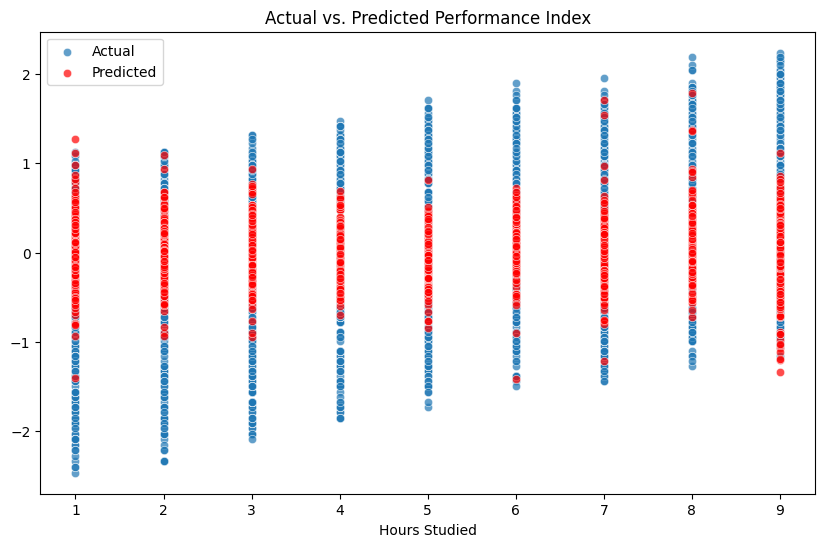

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['Hours Studied'], y=y_test, label='Actual', alpha=0.7)
sns.scatterplot(x=X_test['Hours Studied'], y=pipeline.predict(X_test), label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Performance Index')
plt.show()

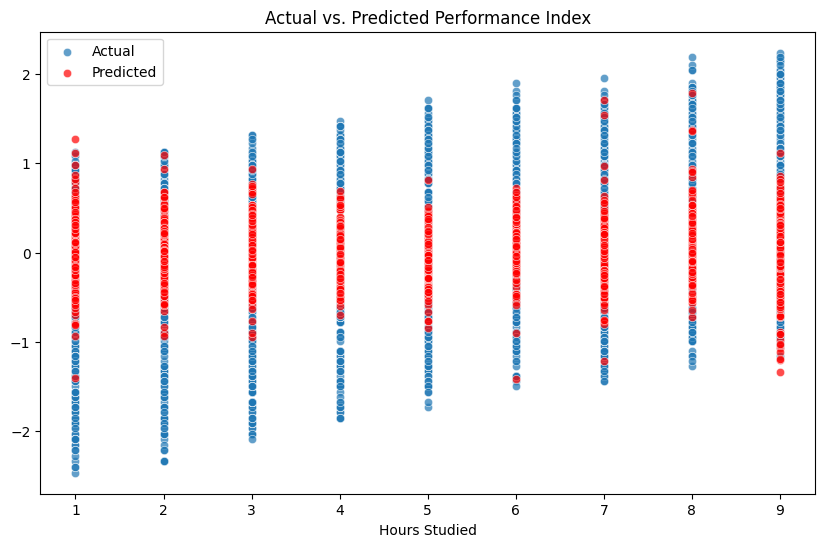

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['Hours Studied'], y=y_test, label='Actual', alpha=0.7)
sns.scatterplot(x=X_test['Hours Studied'], y=pipeline.predict(X_test), label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Performance Index')
plt.show()
